# Step 4: Classification of occupations on inscriptions by their urban context

*AIM*: Classifies the occupational data from inscriptions based on their urban context.

References:

1) `Hanson J. W., An urban geography of the Roman world, 100 BC to AD 300. Oxford: Archaeopress; 2016. http://oxrep.classics.ox.ac.uk/oxrep/docs/Hanson2016/Hanson2016_Cities_OxREP.csv`

2) `Hanson J. W, Ortman S. G., A systematic method for estimating the populations of Greek and Roman settlements. J Roman Archaeol. 2017;30: 301–324.`

3)  `Harris EM. Workshop, Marketplace and Household: The Nature of Technical Specialization in Classical Athens and its Influence on Economy and Society. In: Carledge P, Cohen EE, Foxhall L, editors. Money, Labour and Land: Approaches to the Economy of Ancient Greece. London—New York: Routledge; 2001. pp. 67–99.`

4) `van Leeuwen MHD, Maas I, Miles A. HISCO: Historical International Standard Classification of Occupations. 2022 2002 [cited 27 Jan 2022]. Available: https://historyofwork.iisg.nl/`


This script was originally published by `Kaše V, Heřmánková P, Sobotková A (2022) Division of labor, specialization and diversity in the ancient Roman cities: A quantitative approach to Latin epigraphy. PLoS ONE 17(6): e0269869. https://doi.org/10.1371/journal.pone.0269869` under a CC BY-SA 4.0 International License. 

https://github.com/sdam-au/social_diversity

The *Past Social Networks Project* adapted the script to fit the needs of the project research agenda.

## Data:

### IN:

1) Inscriptions with occupational data and urban contexts `LIST_contexts.parquet`

2) Roman cities `roman_cities_pop.parquet`

3) Roman provinces `pleiades_regions.geojson`

4) Occupations `occupations_list_hisco.csv`



### OUT: 

1) Number of occupations per 1000 inscriptions by context `occups_contexts_descriptive.csv`

2) Inscriptions with occupational industry types `LIST_occupsorgs_industry.parquet`



# Requirements

In [10]:
import pandas as pd
pd.set_option('display.max_columns', 200)
import numpy as np
import geopandas as gpd
import nltk

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import geoplot as gplt

import gspread
from google.oauth2 import service_account # based on google-auth library

import sddk

In [13]:
# global parameters for plots
#plt.style.use("seaborn-white")
plt.style.use("seaborn-v0_8-white")

plt.rcParams['figure.dpi'] = 300
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams['font.size'] = 8

def save_figure(fig, fig_name):
    #each figure to be saved in four different versions
    fig.savefig("../../figures/" + fig_name + ".tiff")
    fig.savefig("../../figures/" + fig_name + ".svg")
    fig.savefig("../../figures/" + fig_name + ".png")
    s.write_file(figpath + fig_name + ".eps", fig)
    s.write_file(figpath + fig_name + ".png", fig)

In [60]:
# to access gsheet, you need Google Service Account key json file
# I have mine located in my personal space on sciencedata.dk, so I read it from there:
# but you can have yours stored locally on your computer and read it in directly
s = sddk.cloudSession("sciencedata.dk", ".", "648560@au.dk")
figpath = "./PSNP_shared/lat_socdiv/"


Your ScienceData username (e.g. '123456@au.dk'):  648560@au.dk
Your ScienceData password:  ········


connection with shared folder failed


NameError: name 'exit' is not defined

In [15]:
file_data = s.read_file("https://sciencedata.dk/files/ServiceAccountsKey.json", "dict")
credentials = service_account.Credentials.from_service_account_info(file_data)
gc = gspread.Client(auth=credentials.with_scopes(['https://spreadsheets.google.com/feeds', 'https://www.googleapis.com/auth/drive']))
socdiv_results = gc.open_by_url("https://docs.google.com/spreadsheets/d/13S9erCJNAdX-35MZ1O0mywa0liVIVJKBgzJxPmmLv9g/edit?usp=sharing")

# Import datasets

In [16]:
# imports the local version
LIST = gpd.read_parquet("../../data/large_data/LIST_contexts.parquet")
LIST.head(3)

,LIST-ID,EDCS-ID,EDH-ID,trismegistos_uri,pleiades_id,transcription,inscription,clean_text_conservative,clean_text_interpretive_sentence,clean_text_interpretive_word,clean_text_interpretive_word_EDCS,diplomatic_text,province,place,inscr_type,status_notation,inscr_process,status,partner_link,last_update,letter_size,type_of_inscription,work_status,year_of_find,present_location,text_edition,support_objecttype,support_material,support_decoration,keywords_term,people,type_of_inscription_clean,type_of_inscription_certainty,height_cm,width_cm,depth_cm,material_clean,type_of_monument_clean,type_of_monument_certainty,province_label_clean,province_label_certainty,country_clean,country_certainty,findspot_ancient_clean,findspot_ancient_certainty,modern_region_clean,modern_region_certainty,findspot_modern_clean,findspot_modern_certainty,findspot_clean,findspot_certainty,language_EDCS,raw_dating,not_after,not_before,Longitude,Latitude,is_geotemporal,geometry,is_within_RE,urban_context,urban_context_city,urban_context_pop_est,type_of_inscription_auto,type_of_inscription_auto_prob,occups,occups_N,organizations,organizations_N,is_western,large_city_ID,large_city_geo,large_city_dist,medium_city_ID,medium_city_geo,medium_city_dist,small_city_ID,small_city_geo,small_city_dist,urban_context_alt
0,445464,EDCS-24900077,HD056163,https://www.trismegistos.org/text/177366,570485,Q(uinto) Caecilio C(ai) f(ilio) Metelo / imper...,Q(uinto) Caecilio C(ai) f(ilio) Metel(l)o / im...,Q Caecilio C f Metelo imperatori Italici quei ...,Quinto Caecilio Cai filio Metelo imperatori It...,Quinto Caecilio Cai filio Metelo imperatori It...,Quinto Caecilio Cai filio Metello imperatori I...,Q CAECILIO C F METELO / IMPERATORI ITALICI / Q...,Achaia,Agia Triada / Merbaka / Midea,tituli honorarii,"officium/professio, ordo senatorius, tria nomi...",None,officium/professio; ordo senatorius; tituli ...,http://db.edcs.eu/epigr/partner.php?s_language...,2011-11-11,None,honorific inscription,no image,NaN,None,\n Quinto Caecilio Cai filio Metelo imperatori...,None,None,1000,69,"[{'age: days': None, 'age: hours': None, 'age:...",honorific inscription,False,NaN,NaN,NaN,NULL,NULL,False,Achaia,False,Greece,False,Midea,False,Pelopónissos,False,Midhéa,False,NULL,False,None,-68 to -68,-68.0,-68.0,22.8412,37.6498,True,POINT (22.841 37.650),True,rural,None,NaN,honorific inscription,1.0,[],0,[],0,False,13,"[22.719769, 37.631278]",10912.81,85,"[22.641069, 37.831664]",26806.86,36,"[23.132244, 37.626573]",25817.21,rural
1,445465,EDCS-03700724,HD052964,https://www.trismegistos.org/text/121715,531064,Fortissimo et piis/simo Caesari d(omino) n(ost...,Fortissimo et Piis/simo Caesari d(omino) n(ost...,Fortissimo et piissimo Caesari d n Gal Val P F...,Fortissimo et piissimo Caesari domino nostro G...,Fortissimo et piissimo Caesari domino nostro G...,Fortissimo et Piissimo Caesari domino nostro G...,FORTISSIMO ET PIIS / SIMO CAESARI D N / GAL VA...,Achaia,Agios Athanasios / Photike,tituli honorarii,"Augusti/Augustae, ordo equester, tria nomina",litterae erasae,Augusti/Augustae; litterae erasae; ordo eque...,http://db.edcs.eu/epigr/partner.php?s_language...,2014-09-16,3-5.3 cm,honorific inscription,checked with photo,NaN,Fragma Kalama,\n Fortissimo et piissimo Caesari domino nostr...,57,None,1000,69,"[{'age: days': None, 'age: hours': None, 'age:...",honorific inscription,False,99.0,67.0,67.0,NULL,statue base,False,Epirus,False,Greece,False,Photike,False,Ípeiros,False,Paramythía,False,{Agios Athanasios},False,None,309 to 313,313.0,309.0,20.7668,39.4512,True,POINT (20.767 39.451),True,rural,None,NaN,honorific inscription,1.0,[],0,[],0,False,65,"[20.733395, 39.026505]",47237.78,7,"[20.987, 39.158]",37687.28,31,"[20.787767, 39.546432]",10725.84,rural
2,445466,EDCS-13800065,HD017714,https://www.trismegistos.org/text/177100,570049,Italicei / quei Aegei negotiantur / P(ublium) ...,Italicei / quei Aegei negotiantur / P(ublium) ...,Italicei quei Aegei negotiantur P Rutilium P f...,Italicei quei Aegei negotiantu

In [18]:
# making sure the data exists and loaded properly, printing out all the attribute names
print(LIST.columns.tolist())

['LIST-ID', 'EDCS-ID', 'EDH-ID', 'trismegistos_uri', 'pleiades_id', 'transcription', 'inscription', 'clean_text_conservative', 'clean_text_interpretive_sentence', 'clean_text_interpretive_word', 'clean_text_interpretive_word_EDCS', 'diplomatic_text', 'province', 'place', 'inscr_type', 'status_notation', 'inscr_process', 'status', 'partner_link', 'last_update', 'letter_size', 'type_of_inscription', 'work_status', 'year_of_find', 'present_location', 'text_edition', 'support_objecttype', 'support_material', 'support_decoration', 'keywords_term', 'people', 'type_of_inscription_clean', 'type_of_inscription_certainty', 'height_cm', 'width_cm', 'depth_cm', 'material_clean', 'type_of_monument_clean', 'type_of_monument_certainty', 'province_label_clean', 'province_label_certainty', 'country_clean', 'country_certainty', 'findspot_ancient_clean', 'findspot_ancient_certainty', 'modern_region_clean', 'modern_region_certainty', 'findspot_modern_clean', 'findspot_modern_certainty', 'findspot_clean', 

In [19]:
# loads cities and regions
roman_cities = gpd.read_file("../../data/roman_cities_pop.geojson")
pleiades_regions = gpd.read_file("../../data/pleiades_regions.geojson")

# Spatial distribution of inscriptions by urban context

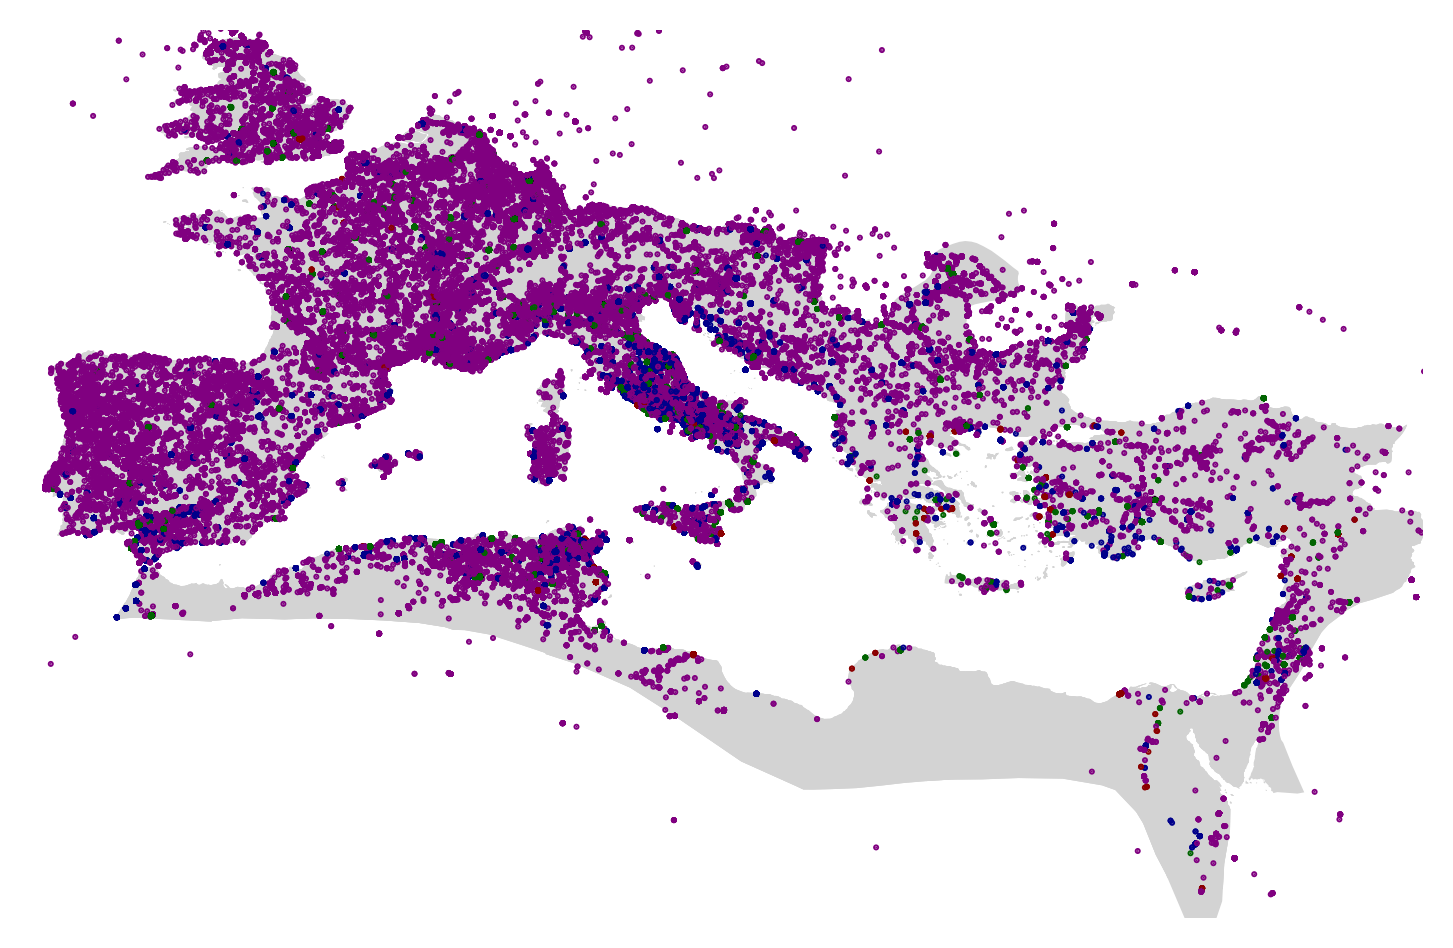

In [20]:
# map of spatial distribution of all inscriptions, colour defined by their urban context type

context_color_dict = {"large" : "darkred",
                      "medium" : "darkgreen",
                      "small" : "darkblue",
                      "rural" : "purple"}
               
colors = LIST["urban_context_alt"].apply(lambda x: context_color_dict[x])

fig, ax = plt.subplots(figsize=(5.2,3.2), tight_layout=True)
pleiades_regions.plot(ax=ax, color="lightgray")
LIST.plot(ax=ax, markersize=0.2, color=colors)
ax.set_axis_off()
ax.set_xlim(-10, 41)
ax.set_ylim(23, 55.5)
plt.show()

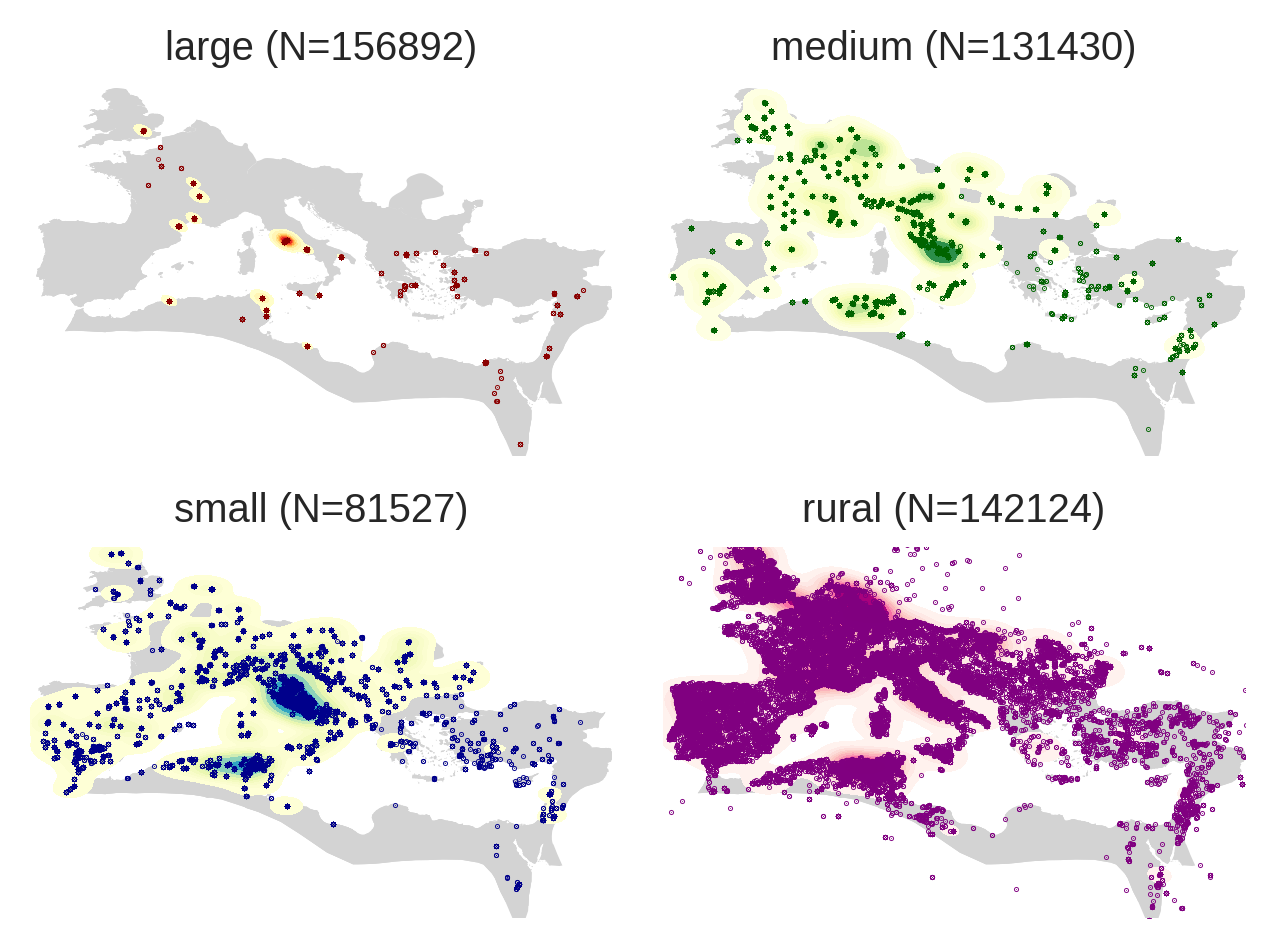

In [21]:
# spatial distribution of all inscriptions split into four maps, each for each urban context, heatmap

#color maps: https://matplotlib.org/stable/tutorials/colors/colormaps.html
#colors: https://matplotlib.org/stable/gallery/color/named_colors.html
fig, axs = plt.subplots(2,2, figsize=(5.2,3.2), tight_layout=True)


for ax, context, color, cmap in zip(
        axs.ravel(),
        ["large", "medium", "small", "rural"],
        ["darkred", "darkgreen", "darkblue","purple"],
        ["YlOrRd", "YlGn", "YlGnBu", "RdPu"]):
    pleiades_regions.plot(ax=ax, color="lightgray")
    df = LIST[LIST["urban_context_alt"]==context]
    gplt.kdeplot(df, cmap=plt.get_cmap(cmap), ax=ax, shade=True, zorder=2)
    df.plot(ax=ax, marker=".", markersize=0.2, color=color, zorder=3)
    ax.set_axis_off()
    ax.set_xlim(-10, 41)
    ax.set_ylim(23, 55.5)
    ax.set_title(context + " (N={0})".format(str(len(df))))


In [22]:
# saves the plot

save_figure(fig, "LIST_spatial_by_urban_context")

A file with the same name ("LIST_spatial_by_urban_context.eps") already exists in this location.


Press Enter to overwrite it or choose different path and filename:  
Unsupported file format. Type either "txt", "csv", "json", "geojson", "feather", or "png":  


Your <class 'matplotlib.figure.Figure'> object has been succesfully written as "https://sciencedata.dk/files/././PSNP_shared/lat_socdiv/LIST_spatial_by_urban_context."
A file with the same name ("LIST_spatial_by_urban_context.png") already exists in this location.


Press Enter to overwrite it or choose different path and filename:  


Your <class 'matplotlib.figure.Figure'> object has been succesfully written as "https://sciencedata.dk/files/././PSNP_shared/lat_socdiv/LIST_spatial_by_urban_context.png"


# Exploration of occupations and organizations by urban context

In [23]:
# OCCUPATIONS frequency accross location categories
for context in ["large", "medium", "small", "rural"]:
    print(context, LIST[LIST["urban_context_alt"]==context]["occups_N"].sum() / len(LIST[LIST["urban_context_alt"]==context]))

large 0.026279223924738037
medium 0.01903674960054782
small 0.026432960859592528
rural 0.011060763840027018


In [24]:
# OCCUPATIONS frequency accross location categories - WESTERN
for context in ["large", "medium", "small", "rural"]:
    print(context, LIST[(LIST["urban_context_alt"]==context) & (LIST["is_western"])]["occups_N"].sum() / len(LIST[LIST["urban_context_alt"]==context]))

large 0.025667338041455268
medium 0.01703568439473484
small 0.02191911881953218
rural 0.009414314260786356


In [25]:
# ORGANIZATIONS frequency accross location categories
for context in ["large", "medium", "small", "rural"]:
    print(context, LIST[LIST["urban_context_alt"]==context]["organizations_N"].sum() / len(LIST[LIST["urban_context_alt"]==context]))

large 0.009222904928230885
medium 0.005234725709503158
small 0.007457652066186662
rural 0.003314007486420309


In [26]:
# ORGANIZATIONS frequency accross location categories
for context in ["large", "medium", "small", "rural"]:
    print(context, LIST[(LIST["urban_context_alt"]==context) & (LIST["is_western"])]["organizations_N"].sum() / len(LIST[LIST["urban_context_alt"]==context]))

large 0.009082681079978583
medium 0.0048771209008597735
small 0.005666834300293154
rural 0.0028425881624496918


## Occupations within urban contexts - bootstrap test

based on Brezina 2018, p. 232, drawing on Lijffijt 2016

In [27]:
def get_bootstrap(df, n_of_bootstraps, bootstrap_size, column, row_function=None):
    bootstrap_values = []
    for n in range(n_of_bootstraps):
        sample_df = df.sample(bootstrap_size, replace=True)
        if row_function == None:
            bootstrap_values.append(sample_df[column].sum())
        else:
            bootstrap_values.append(sample_df[column].apply(row_function).mean())
    return bootstrap_values

def get_statistics(df1, df2, n_of_bootstraps, bootstrap_size, column, row_function=None):
    bootstrap_test_values = []
    df1_values = get_bootstrap(df1, n_of_bootstraps, bootstrap_size, column, row_function)
    df2_values = get_bootstrap(df2, n_of_bootstraps, bootstrap_size, column, row_function)
    # H values
    H_list = []
    for n in range(n_of_bootstraps):
        if df1_values[n] == df2_values[n]:
            H_list.append(0.5)
        else:
            if df1_values[n] > df2_values[n]:
                H_list.append(1)
            else:
                H_list.append(0)
    # CONFIDENCE INTERVAL (950) for the difference
    difference = np.array(df1_values) - np.array(df2_values)
    CI95 = (np.percentile(difference, 2.5), np.percentile(difference, 97.5))
    # COHENS DELTA
    pooled_sd = np.sqrt(((len(df1_values) - 1) * ((np.std(df1_values)**2))) + ((len(df2_values) - 1) * (np.std(df2_values)**2)) / (len(df1_values) + len(df2_values) + 2))
    cohens_delta = (np.mean(df1_values) - np.mean(df2_values)) / pooled_sd
    return H_list, cohens_delta, CI95, [df1_values, df2_values]

def bootstrap_test(df1, df2, n_of_bootstraps, bootstrap_size, column, row_function=None):
    H_values, cohens_delta, CI95, data = get_statistics(df1, df2, 1000, 1000, column, row_function)
    p1 =  sum(H_values) / len(H_values)
    p = (1 + (2 * len(H_values) * np.min((p1, 1 - p1)))) / (1 + len(H_values))
    return p, cohens_delta, CI95, data

### Occupations within urban contexts

In [28]:
# LIST - occupations all-URBAN vs RURAL areas
p, cohens_d, CI95, LIST_occups_urban_rural = bootstrap_test(LIST[~(LIST["urban_context_alt"]=="rural")], LIST[LIST["urban_context_alt"]=="rural"], 1000, 1000, "occups_N")
p, cohens_d, CI95

(0.07092907092907098, 0.05852658634024204, (-1.0, 30.0))

(0.024975024975024997, 0.08822564287536085, (4.0, 45.0))

In [29]:
# LIST - occupations LARGE vs MEDIUM city areas
p, cohens_d, CI95, LIST_occups_large_medium = bootstrap_test(LIST[LIST["urban_context_alt"]=="large"], LIST[LIST["urban_context_alt"]=="medium"], 1000, 1000, "occups_N")
p, cohens_d, CI95

(0.41258741258741255, 0.030974516106554866, (-14.0, 25.024999999999977))

In [30]:
# LIST - occupations SMALL vs RURAL areas
p, cohens_d, CI95, LIST_occups_small_rural = bootstrap_test(LIST[LIST["urban_context_alt"]=="small"], LIST[LIST["urban_context_alt"]=="rural"], 1000, 1000, "occups_N")
p, cohens_d, CI95

(0.029970029970029885, 0.07756870721691991, (2.0, 31.0))

### Number of occupations per 1,000 inscriptions by their urban context

In [31]:
labels=[
    "large city",
    "medium city",
    "small city",
    "rural area"
]

In [32]:
len(LIST_occups_large_medium + LIST_occups_small_rural)

4

In [33]:
stat_series = []
for label, data in zip(labels, LIST_occups_large_medium + LIST_occups_small_rural):
    stat_series.append(pd.Series(data).describe())

In [34]:
# Number of occupations per 1,000 inscriptions by their urban context

contexts = labels
measurements = ["occups. per 1,000 ins."] * 4

occups_contexts_descriptive = pd.DataFrame([measurements, contexts], index=["measurement","context"]).T.join(pd.DataFrame(stat_series))

for col in ["count",  "min", "25%", "50%", "75%", "max"]:
    occups_contexts_descriptive[col] = occups_contexts_descriptive[col].astype(int)
occups_contexts_descriptive.drop("count", inplace=True, axis=1)
occups_contexts_descriptive.rename(columns={"count" : "N of bootstraps"}, inplace=True)
occups_contexts_descriptive = occups_contexts_descriptive.round(2)
occups_contexts_descriptive

,measurement,context,mean,std,min,25%,50%,75%,max
0,"occups. per 1,000 ins.",large city,26.09,7.05,9,21,25,30,59
1,"occups. per 1,000 ins.",medium city,19.19,6.86,6,15,18,22,63
2,"occups. per 1,000 ins.",small city,26.52,6.27,6,22,26,31,49
3,"occups. per 1,000 ins.",rural area,11.16,4.31,1,8,11,14,35


In [35]:
# printout in a different format

print(occups_contexts_descriptive.to_latex(index=False, bold_rows=True, multirow=True))

\begin{tabular}{llrrrrrrr}
\toprule
measurement & context & mean & std & min & 25% & 50% & 75% & max \\
\midrule
occups. per 1,000 ins. & large city & 26.090000 & 7.050000 & 9 & 21 & 25 & 30 & 59 \\
occups. per 1,000 ins. & medium city & 19.190000 & 6.860000 & 6 & 15 & 18 & 22 & 63 \\
occups. per 1,000 ins. & small city & 26.520000 & 6.270000 & 6 & 22 & 26 & 31 & 49 \\
occups. per 1,000 ins. & rural area & 11.160000 & 4.310000 & 1 & 8 & 11 & 14 & 35 \\
\bottomrule
\end{tabular}



In [36]:
# saves the boxplot
occups_contexts_descriptive.to_csv("../../data/occups_contexts_descriptive.csv")

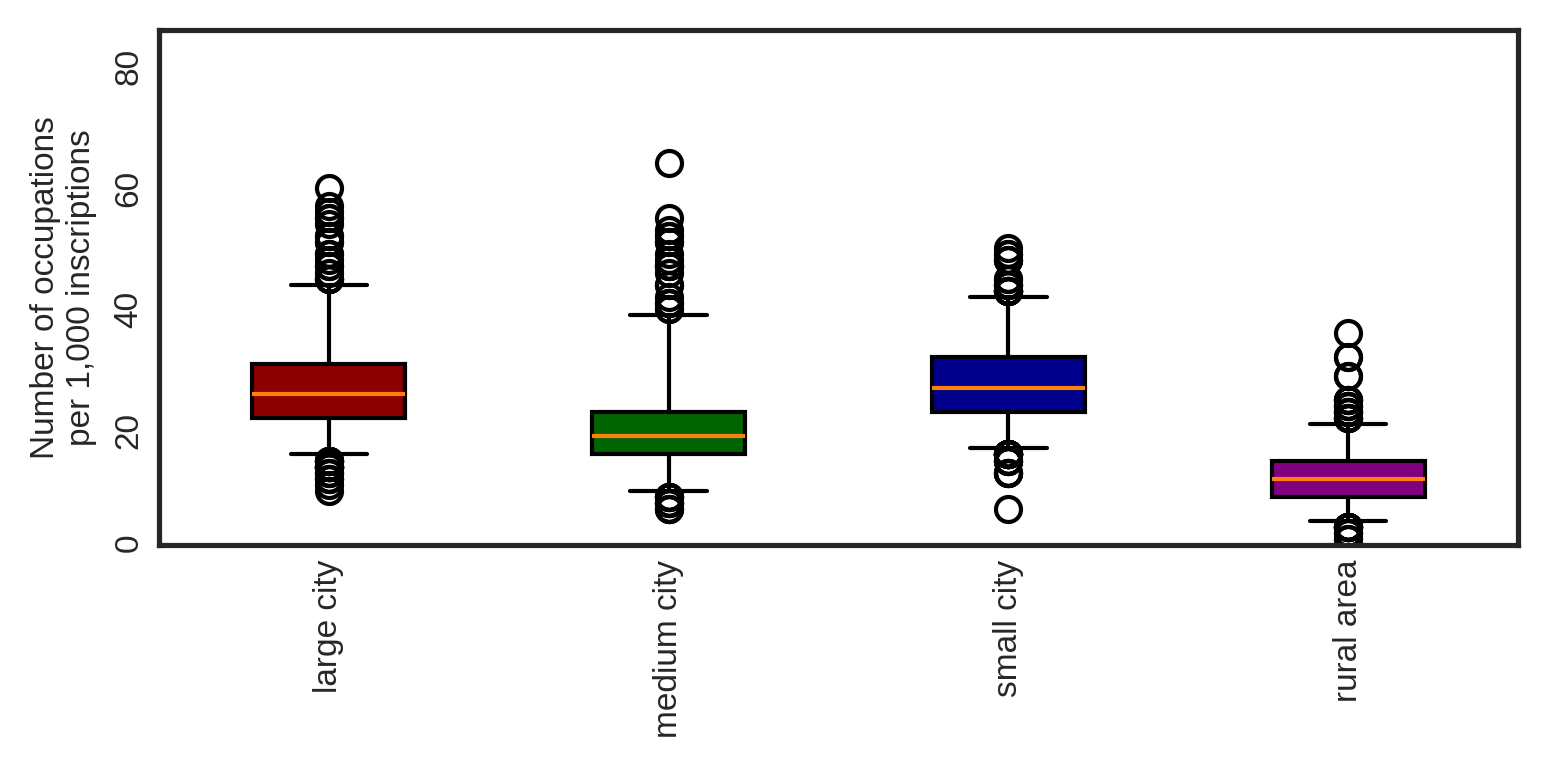

In [37]:
# Number of occupations per 1,000 inscriptions by urban context

tab_colors_list = list(mcolors.TABLEAU_COLORS.keys())

fig, ax1 = plt.subplots(figsize=[5.2, 2.6], tight_layout=True)

bplot1 = ax1.boxplot(LIST_occups_large_medium + LIST_occups_small_rural, whis=[2.5, 97.5], labels=labels,
                     patch_artist=True)
#ax1.set_title("A")
ax1.set_ylabel("Number of occupations\nper 1,000 inscriptions")
ax1.tick_params(labelrotation=90)
ax1.set_ylim(0, 85)

# fill with colors
colors = ["darkred", "darkgreen", "darkblue", "purple"]
#for bplot in bplot1:
for patch, color in zip(bplot1['boxes'], colors):
    patch.set_facecolor(color)

In [38]:
save_figure(fig, "LIST_occups_by_context_box")


Unsupported file format. Type either "txt", "csv", "json", "geojson", "feather", or "png":  


Your <class 'matplotlib.figure.Figure'> object has been succesfully written as "https://sciencedata.dk/files/././PSNP_shared/lat_socdiv/LIST_occups_by_context_box."
Your <class 'matplotlib.figure.Figure'> object has been succesfully written as "https://sciencedata.dk/files/././PSNP_shared/lat_socdiv/LIST_occups_by_context_box.png"


# Exploration of occupations by their industry type

In [39]:
# generate a dictionary of occupations by type
occupations_df = pd.read_csv("../../data/occupations_list_hisco.csv")

def term1_plus_term2(row):
    term1_2 = row["Term"]
    if isinstance(row["Term2"], str):
        term1_2 += " " + row["Term2"]
    return term1_2

occupations_df["Term"] = occupations_df.apply(lambda row: term1_plus_term2(row), axis=1)

occups_cats_dict = dict(zip(occupations_df["Term"], occupations_df["Harris_Category"]))

In [40]:
def cat_for_occup(list_of_occups):
    try:
        return [occups_cats_dict[occup] for occup in list_of_occups]
    except:
        return []
LIST["occups"] = LIST["occups"].apply(list)
LIST["occups_cats"] = LIST["occups"].apply(cat_for_occup)

## Categorisation of urban contexts and industry categories by Harris 2001

In [41]:
edhcs_occups_cats_data = {}
contexts = ["large", "medium", "small", "rural"]
labels = ["large city", "medium city", "small city", "rural area"]

edhcs_all_present_categories = []
for context, label in zip(
    contexts,
    labels
):
    df_subset = LIST[LIST["urban_context_alt"]==context]
    occups_cats_list = [el for sublist in df_subset["occups_cats"].tolist() for el in sublist]
    #wordcount = df_subset["clean_text_interpretive_word"].astype("str").apply(lambda x: len(x.split())).sum()
    occups_cats_dist = nltk.FreqDist(occups_cats_list).most_common()
    categories = [tup[0] for tup in occups_cats_dist]
    edhcs_all_present_categories.extend(categories[:10])
    #freqs = [(tup[1] / wordcount) * 10000 for tup in occups_cats_dist]
    freqs = [(tup[1] / len(df_subset)) * 1000 for tup in occups_cats_dist]
    cat_freq_dict = dict(zip(categories[:10], freqs[:10]))
    total_freq = np.sum(freqs)
    edhcs_occups_cats_data[label] = {"categories" : categories, "freqs" : freqs, "cat_freq_dict" : cat_freq_dict,"total_freq" : total_freq}
    print(categories, freqs, total_freq)
edhcs_all_present_categories = list(set(edhcs_all_present_categories))

['Managerial', 'Miscellaneous Services', 'Metal-Working', 'Retail', 'Building', 'Food-Production', 'Education', 'Clothing', 'Transport', 'Unclassified', 'Household Goods', 'Performing Arts', 'Finance', 'Plastic Arts', 'Food-Retail', 'Water-Management', 'Glass-Working', 'Fuel / Raw material', 'Death-care sector'] [4.442546465084261, 4.219463070137419, 2.8873365117405605, 2.587767381383372, 2.205338704331642, 1.9695076868164085, 1.4914718405017464, 1.47235040664916, 1.1472860311551896, 0.898707391071565, 0.6819978074089182, 0.6055120719985723, 0.6055120719985723, 0.43979297860948935, 0.36330724319914337, 0.15297147082069193, 0.07648573541034596, 0.01912143385258649, 0.012747622568390994] 26.279223924738037
['Managerial', 'Miscellaneous Services', 'Unclassified', 'Metal-Working', 'Retail', 'Performing Arts', 'Building', 'Clothing', 'Food-Production', 'Education', 'Transport', 'Finance', 'Plastic Arts', 'Household Goods', 'Food-Retail', 'Glass-Working', 'Water-Management', 'Death-care sect

In [42]:
# overview of occupational industry categories

edhcs_data_by_category = {}
for cat in edhcs_all_present_categories:
    cat_data = []
    for label in labels:
        try:
            cat_data.append(edhcs_occups_cats_data[label]["cat_freq_dict"][cat])
        except:
            cat_data.append(0)
    edhcs_data_by_category[cat] = cat_data
edhcs_data_by_category

{'Performing Arts': [0,
  1.483679525222552,
  1.2388533859948239,
  0.5065998705355886],
 'Food-Production': [1.9695076868164085,
  0.8673818762839535,
  0,
  0.35884157496270863],
 'Education': [1.4914718405017464,
  0.6162976489385985,
  1.2511192611036834,
  0.38698601221468576],
 'Metal-Working': [2.8873365117405605,
  1.613025945370159,
  2.3795797711187707,
  1.6112690326756915],
 'Building': [2.205338704331642,
  1.10324887772959,
  1.9012106418732444,
  0.7387914778644001],
 'Transport': [1.1472860311551896, 0, 0.8708771327290346, 0],
 'Retail': [2.587767381383372,
  1.6054173324202998,
  1.0793970095796483,
  0.7739720244293715],
 'Clothing': [1.47235040664916,
  1.0499885870805754,
  1.9257423920909638,
  0.6754664940474515],
 'Unclassified': [0.898707391071565,
  2.3510614015065054,
  4.194929287229997,
  1.203174692522023],
 'Managerial': [4.442546465084261,
  3.994521798676101,
  7.408588565751224,
  2.41338549435704],
 'Miscellaneous Services': [4.219463070137419,
  2.50

In [43]:
# sorts industry types by Harris 2001

sorted_by_large = sorted([(key,edhcs_data_by_category[key]) for key in edhcs_data_by_category], key=lambda tup: tup[1][0], reverse=True)
sorted_by_large_cats =[el[0] for el in sorted_by_large if el[0] != "Unclassified"] + ["Unclassified"]
sorted_by_large_cats

['Managerial',
 'Miscellaneous Services',
 'Metal-Working',
 'Retail',
 'Building',
 'Food-Production',
 'Education',
 'Clothing',
 'Transport',
 'Performing Arts',
 'Unclassified']

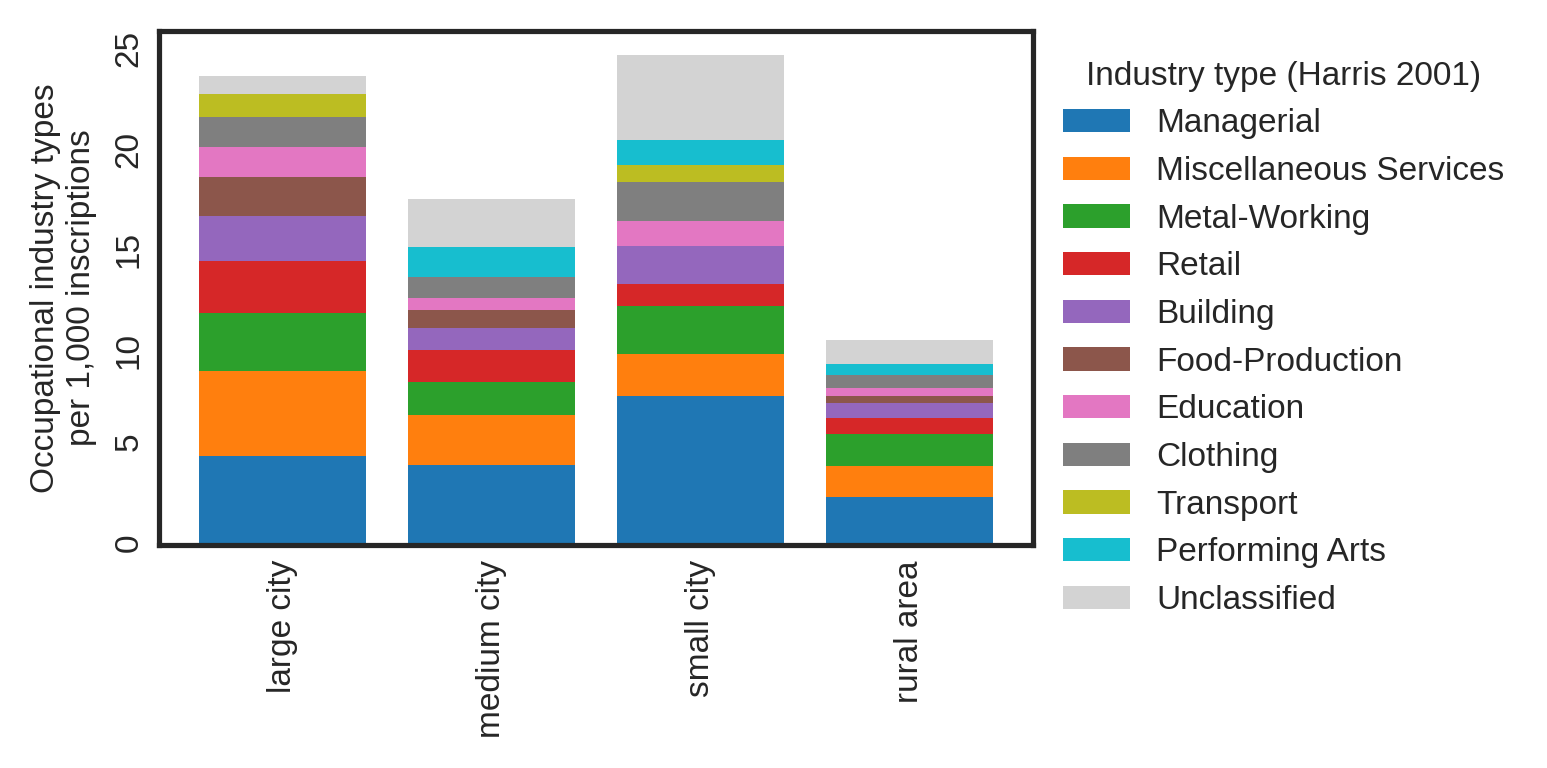

In [44]:
# plots the occupations per 1000 inscriptions by their industry type (Harris 2001) and their urban context

fig, ax = plt.subplots(figsize=[5.2,2.6], tight_layout=True)
#first_bar_cat = sorted_by_large_cats[0]
ax.bar(labels, edhcs_data_by_category[sorted_by_large_cats[0]], label=sorted_by_large_cats[0])
bottom = edhcs_data_by_category[sorted_by_large_cats[0]]

ax.tick_params(labelrotation=90)

for cat in sorted_by_large_cats[1:]:# list(edhcs_data_by_category.keys())[1:]:
    if cat=="Unclassified":
        ax.bar(labels, edhcs_data_by_category[cat], bottom = bottom, color="lightgray", label=cat)
    else:
        ax.bar(labels, edhcs_data_by_category[cat], bottom = bottom, label=cat)
    bottom += np.array(edhcs_data_by_category[cat])
ax.set_ylabel("Occupational industry types\nper 1,000 inscriptions")

ax.legend(title="Industry type (Harris 2001)", bbox_to_anchor=(1, 1), fontsize=8)

In [46]:
save_figure(fig, "LIST_occups_industrytypes_harris_bar")

Unsupported file format. Type either "txt", "csv", "json", "geojson", "feather", or "png":  


Your <class 'matplotlib.figure.Figure'> object has been succesfully written as "https://sciencedata.dk/files/././PSNP_shared/lat_socdiv/LIST_occups_industrytypes_harris_bar."
Your <class 'matplotlib.figure.Figure'> object has been succesfully written as "https://sciencedata.dk/files/././PSNP_shared/lat_socdiv/LIST_occups_industrytypes_harris_bar.png"


## Categorisation of urban contexts and industry categories by HISCO

In [48]:
occupations_df["Term"] = occupations_df["Term"].apply(lambda x: x.replace(" ", "_"))

In [49]:
hisco_cats_dict = {
    0.0 : "Professional, technical and related workers",
    1.0 : "Professional, technical and related workers",
    2.0 : "Administrative and managerial workers",
    3.0 : "Clerical and related workers",
    4.0 : "Sales workers",
    5.0 : "Service workers",
    6.0 : "Agricultural, animal husbandry and forestry workers, fishermen and hunters",
    7.0 : "Production and related workers, transport equipment operators and labourers",
    8.0 : "Production and related workers, transport equipment operators and labourers",
    9.0 : "Production and related workers, transport equipment operators and labourers",
}

In [50]:
hisco_cats_labels = list(set(hisco_cats_dict.values())) + ["Unclassified"]
hisco_cats_labels

['Service workers',
 'Clerical and related workers',
 'Professional, technical and related workers',
 'Production and related workers, transport equipment operators and labourers',
 'Administrative and managerial workers',
 'Agricultural, animal husbandry and forestry workers, fishermen and hunters',
 'Sales workers',
 'Unclassified']

In [51]:
def hisco_literary(hisco_code):
    try:
        return hisco_cats_dict[float(hisco_code)]
    except:
        return "unclassified"
occupations_df["hisco_cats"] = occupations_df["HISCO_majorgroup"].apply(hisco_literary)

In [52]:
occups_cats_dict = dict(zip(occupations_df["Term"], occupations_df["hisco_cats"]))
def cat_for_occup(list_of_occups):
    try:
        return [occups_cats_dict[occup] for occup in list_of_occups]
    except:
        return []
LIST["occups_cats"] = LIST["occups"].apply(cat_for_occup)

In [53]:
edhcs_occups_cats_data = {}

contexts = ["large", "medium", "small", "rural"]
labels = ["large city", "medium city", "small city", "rural area"]

edhcs_all_present_categories = []
for context, label in zip(
    contexts,
    labels
):
    df_subset = LIST[LIST["urban_context_alt"]==context]
    occups_cats_list = [el for sublist in df_subset["occups_cats"].tolist() for el in sublist]
    #wordcount = df_subset["clean_text_interpretive_word"].astype("str").apply(lambda x: len(x.split())).sum()
    occups_cats_dist = nltk.FreqDist(occups_cats_list).most_common()
    categories = [tup[0] for tup in occups_cats_dist]
    edhcs_all_present_categories.extend(categories[:10])
    freqs = [(tup[1] / len(df_subset)) * 1000 for tup in occups_cats_dist]
    cat_freq_dict = dict(zip(categories[:10], freqs[:10]))
    total_freq = np.sum(freqs)
    edhcs_occups_cats_data[label] = {"categories" : categories, "freqs" : freqs, "cat_freq_dict" : cat_freq_dict,"total_freq" : total_freq}
    print(categories, freqs, total_freq)
edhcs_all_present_categories = list(set(edhcs_all_present_categories))

['Production and related workers, transport equipment operators and labourers', 'Administrative and managerial workers', 'Professional, technical and related workers', 'Service workers', 'Sales workers', 'Clerical and related workers', 'Agricultural, animal husbandry and forestry workers, fishermen and hunters', 'unclassified'] [8.566402365958748, 4.155724957295464, 3.6713152996966065, 2.727991229635673, 2.6260102490885453, 1.9758814981006043, 0.8413430895138057, 0.01912143385258649] 24.583790123142034
['Production and related workers, transport equipment operators and labourers', 'Administrative and managerial workers', 'Professional, technical and related workers', 'Sales workers', 'Service workers', 'Clerical and related workers', 'Agricultural, animal husbandry and forestry workers, fishermen and hunters', 'unclassified'] [6.832534428973599, 3.857566765578635, 3.4010499885870806, 1.5749828806208628, 1.2630297496766338, 1.080423038880012, 0.45651677699155446, 0.007608612949859241] 1

In [54]:
edhcs_occups_cats_data

{'large city': {'categories': ['Production and related workers, transport equipment operators and labourers',
   'Administrative and managerial workers',
   'Professional, technical and related workers',
   'Service workers',
   'Sales workers',
   'Clerical and related workers',
   'Agricultural, animal husbandry and forestry workers, fishermen and hunters',
   'unclassified'],
  'freqs': [8.566402365958748,
   4.155724957295464,
   3.6713152996966065,
   2.727991229635673,
   2.6260102490885453,
   1.9758814981006043,
   0.8413430895138057,
   0.01912143385258649],
  'cat_freq_dict': {'Production and related workers, transport equipment operators and labourers': 8.566402365958748,
   'Administrative and managerial workers': 4.155724957295464,
   'Professional, technical and related workers': 3.6713152996966065,
   'Service workers': 2.727991229635673,
   'Sales workers': 2.6260102490885453,
   'Clerical and related workers': 1.9758814981006043,
   'Agricultural, animal husbandry and 

In [55]:
hisco_cats_labels = [
    "Professional, technical and related workers",
    "Administrative and managerial workers",
    "Clerical and related workers",
    "Sales workers",
    "Service workers",
    "Agricultural, animal husbandry and forestry workers, fishermen and hunters",
    "Production and related workers, transport equipment operators and labourers",
    "Unclassified"
]

In [56]:
edhcs_data_by_category = {}
for cat in hisco_cats_labels:
    cat_data = []
    for label in labels:
        try:
            cat_data.append(edhcs_occups_cats_data[label]["cat_freq_dict"][cat])
        except:
            cat_data.append(0)
    edhcs_data_by_category[cat] = cat_data
edhcs_data_by_category

{'Professional, technical and related workers': [3.6713152996966065,
  3.4010499885870806,
  3.2627227789566646,
  1.5549801581717373],
 'Administrative and managerial workers': [4.155724957295464,
  3.857566765578635,
  7.175536938682891,
  2.378204947792069],
 'Clerical and related workers': [1.9758814981006043,
  1.080423038880012,
  1.8398812663289463,
  0.5910331822915201],
 'Sales workers': [2.6260102490885453,
  1.5749828806208628,
  1.128460510015087,
  0.7317553685514058],
 'Service workers': [2.727991229635673,
  1.2630297496766338,
  0.7604842567492978,
  0.4643832146576229],
 'Agricultural, animal husbandry and forestry workers, fishermen and hunters': [0.8413430895138057,
  0.45651677699155446,
  0.36797625326578925,
  0.22515549801581716],
 'Production and related workers, transport equipment operators and labourers': [8.566402365958748,
  6.832534428973599,
  10.732640720252187,
  4.861951535279052],
 'Unclassified': [0, 0, 0, 0]}

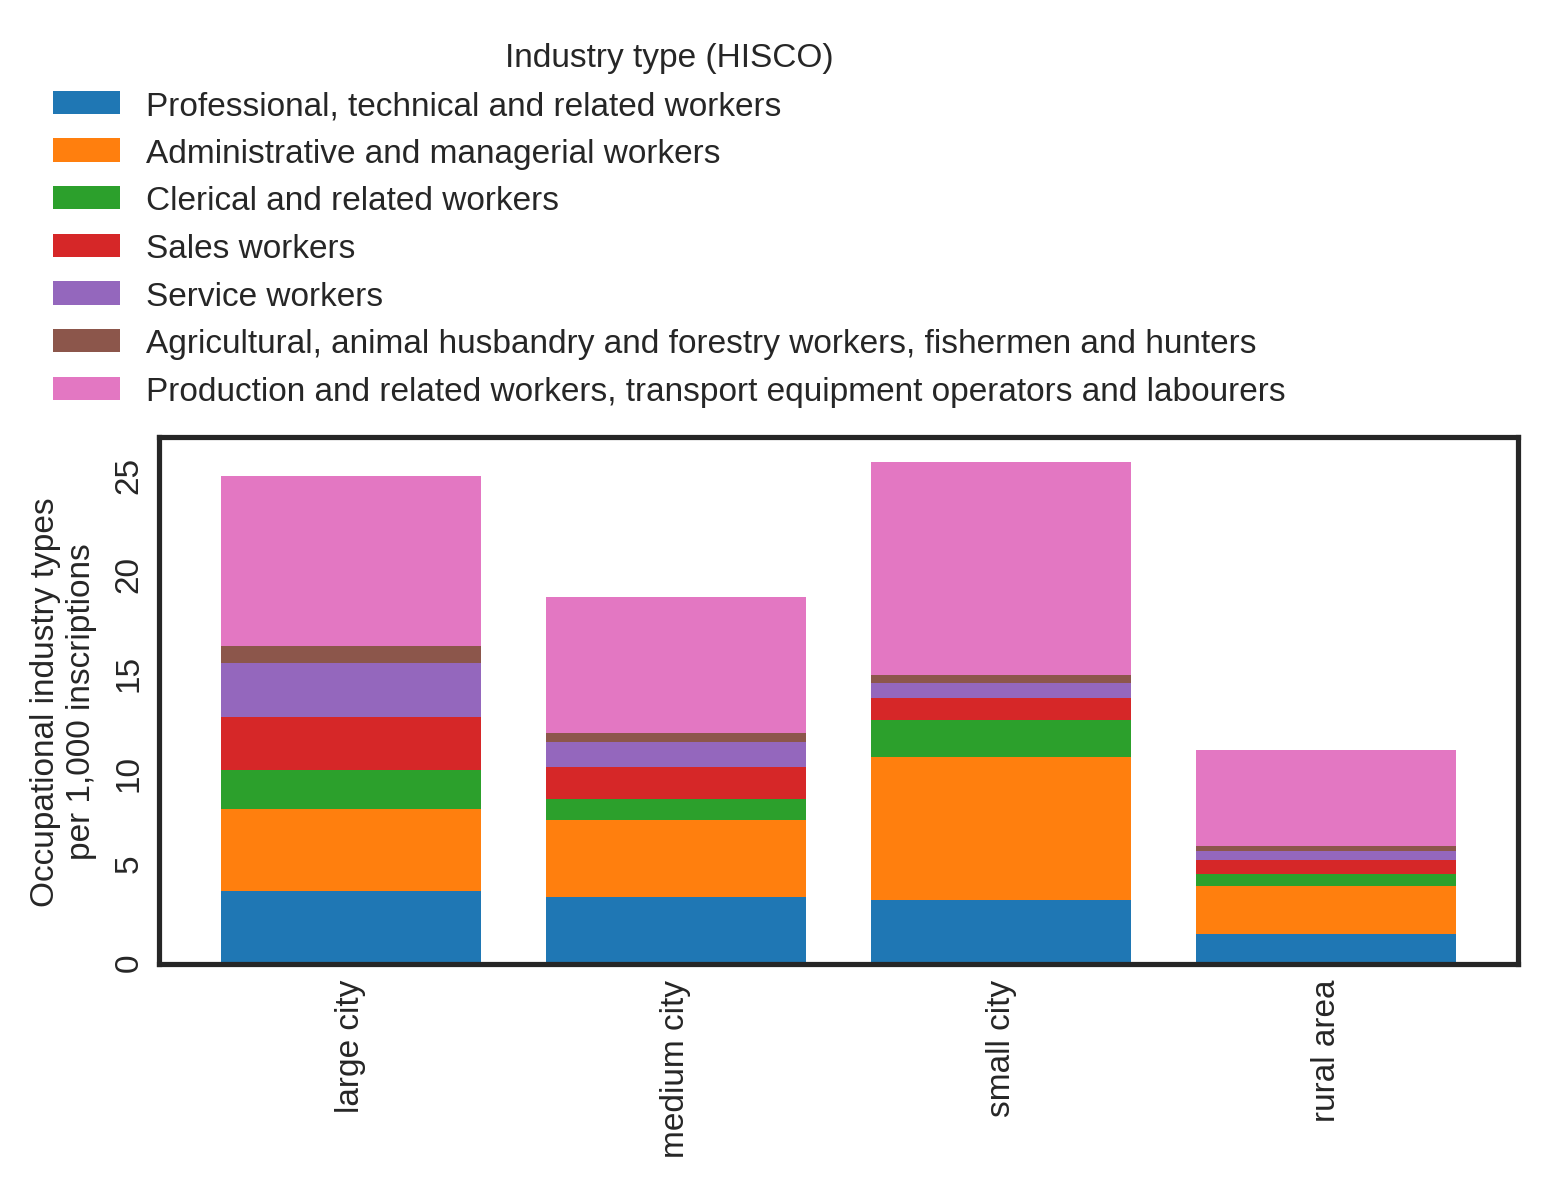

In [57]:
# plots the occupations per 1000 inscriptions by their industry type (HISCO) and their urban context

fig, ax = plt.subplots(figsize=[5.2,4], tight_layout=True)
first_bar_cat = hisco_cats_labels[0]

ax.bar(labels, edhcs_data_by_category[first_bar_cat], label=first_bar_cat)
bottom = edhcs_data_by_category[first_bar_cat]

ax.tick_params(labelrotation=90)

for cat in hisco_cats_labels[1:-1]:
    ax.bar(labels, edhcs_data_by_category[cat], bottom = bottom, label=cat)
    bottom += np.array(edhcs_data_by_category[cat])
ax.set_ylabel("Occupational industry types\nper 1,000 inscriptions")
ax.legend(title="Industry type (HISCO)", bbox_to_anchor=(-0.1, 1), loc="lower left", fontsize=8)

In [58]:
save_figure(fig, "occups_industrytypes_hisco_bar")

A file with the same name ("occups_industrytypes_hisco_bar.eps") already exists in this location.


Press Enter to overwrite it or choose different path and filename:  
Unsupported file format. Type either "txt", "csv", "json", "geojson", "feather", or "png":  


Your <class 'matplotlib.figure.Figure'> object has been succesfully written as "https://sciencedata.dk/files/././PSNP_shared/lat_socdiv/occups_industrytypes_hisco_bar."
A file with the same name ("occups_industrytypes_hisco_bar.png") already exists in this location.


Press Enter to overwrite it or choose different path and filename:  


Your <class 'matplotlib.figure.Figure'> object has been succesfully written as "https://sciencedata.dk/files/././PSNP_shared/lat_socdiv/occups_industrytypes_hisco_bar.png"


In [59]:
LIST.to_parquet("../../data/large_data/LIST_occupsorgs_industry.parquet")